## 1.Introdução

Continuaremos nossa análise exploratória enquanto examinamos uma **variável aleatória**. Daremos prioridade para soluções movidas por modelos de machine learning, atrelados à pacotes relacionais a na área; vamos conhecer técnicas para avaliar nossos modelos de predição. 

Por fim, levaremos para o plano empresarial, focando na análise financeira.

### 1.1.Bibliotecas usadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['figure.figsize'] = [20, 8]

## 2.Por onde começar?

Vamos começar com o objetivo de encontrar a proporção da classe positiva, obtendo a média da variável de resposta no dataset inteiro. Ela é a interpretação da taxa de inadimplência.

## 3.Examinando a variável de resposta e concluindo a exploração inicial

A variável de resposta, para o nosso problema, ele é uma flag binária indicando se uma conta ou não ficará ou não inadimplente no próximo mês, que seria outubro no histórico do dataset.

Criaremos um modelo preditivo de **classificação binária**, ou seja, uma classe positiva e outra negativa.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DADOS/dados_limpos_usuarios_de_credito_DATACLEAN.csv')
df.groupby('default payment next month')['ID'].count()

default payment next month
0    20750
1     5914
Name: ID, dtype: int64

A obtenção da média da coluna acima é de 22% para nossa classe positiva (inadimplência = 1). Essa é uma proporção da amostra também conhecida como **fração da classe**.

Na classificação binária, os datasets são descritos considerando se eles são **balanceados** ou **desbalanceados**: as proporções de amostras positivas e negativas são simétricas?

Geralmente, a maioria dos modelos de classificação de machine learning são progetadas para operarem com dados balanceados: uma divisão 50/50 entre as classes.

No entanto, raramente os dados são balanceados na vida real. Mas não quer dizer que não haja métodos que lidam com dados desbalanceados.Tais como:

* **Subamostragem (undersampling)**: da classe majogitária: eliminar aleatóriamente amostras da classe majoritária até as frações das classses serem iguais, ou no mínimo serem menos desbalanceadas;
* **Sobreamostragem (oversampling)**: da classe minoritária: adicionar aleatóriamente amostras duplicadas da classe minoritária para atingir o mesmo objetivo;
* **Ponderação de amostras (weighting samples)**: esse método é executado como parte da etapa de treinamento, para que a classe minoritária receba coletivamente a mesma "ênfase" da classe majoritária no modelo ajustado. O efeito é semelhante ao do oversampling.

Embora nossos dados não estejam balanceados, é bom ressaltar que uma fração pequena, que seja abaixo de 50%, não é particularmente um desbalanceamento. Normalmente, algumas áreas, como a detecção de fraudes, lidam com frações de classes positivas na ordem de 1% ou menos. Isso ocorre porque a proporção de "malfeitores" é muito pequena em comparação com o conjunto total de transações; ao mesmo tempo, é importante identificá-los se possível.

À medida que criamos modelos e geramos novos resultados, é recomendável pensar no que esses resultados informam sobre os dados, o que em geral requer uma volta rápida à fase de exploração.

E para essa volta de exploração, vamos focar em **examinar o relacionamento entre os atributos e as respostas.**

Agora uma boa prática como profissional na área de ciencia de dados. Em uma fase de relacionar atributos e respostas, tenha em mente essas seguintes perguntas:

* Os dados estão completos? **Há valores ausentes, anomalias ou dicrepâncias?**
* Os dados são consistentes? **A distribuição muda com o tempo? Essa mudança tem alguma relação?**
* Os dados como um todo fazem sentido? **Os valores das características correspondem à sua definição no dicionário de dados?**

Respostas insatisfatórias em qualquer uma dessas perguntas devem ser corrigidas antes do projeto dar continuidade.

## 4.Criando modelos de machine learning com o pacote SCIKIT-LEARN

Vamos começar com um dos modelos de classificação mais importantes por sua praticidade e interpretabilidade, a **regressão logística**. Vamos instanciá-lo a partir da classe fornecida pelo scikit-learn. Isso significa dizer que você estará obtendo o blueprint do modelo e criando um modelo útil a partir dele. 

In [5]:
# criando um objeto, configurando os parâmetros e guardando em uma variável
my_lr = LogisticRegression(C= 0.1,
                           class_weight= None,
                           dual= False,
                           fit_intercept= True,
                           intercept_scaling= 1,
                           max_iter= 100,
                           multi_class= 'warn',
                           n_jobs= None,
                           penalty= 'l2',
                           random_state= None,
                           solver= 'liblinear',
                           tol= 0.0001,
                           verbose= 0,
                           warm_start= False) 
my_lr

LogisticRegression(C=0.1, multi_class='warn', solver='liblinear')

## 5.Gerando dados sintéticos

Para ter dados para ajustar, você gerará seus próprios dados sintéticos. Teremos o auxilio da biblioteca *random* do NumPy para a geração de números aleatórios.

Para começar, usaremos o NumPy para criar um array unidimencional de valores e carcterísticas chamado X e composto por 1.000 números reais aleatórios (inteiros e decimais) entre 0 e 10. Empregaremos um **seed** para o gerador de números aleatórios. Em seguida, criaremos uma uniformidade que retornará um array com o tamanho (size) que você especificar. Criaremos um array unidimencional (vetor) composto por 1.000 elementos e examinaremos os 10 primeiros.

In [6]:
np.random.seed(seed= 1)

In [7]:
X = np.random.uniform(low= 0.0,
                      high= 10.0,
                      size= (1000,))
X[0:10]

array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])

## 6.Dados para uma regressão linear

Agora vamos criar uma variável de resposta. Geraremos dados que se baseiam nas suposições da regressão linear: obedeçam a uma tendência linear, mas tem erros normalmente distribuídos. Teoricamente, a regressão linear só deve ser usada para modelar dados em que a resposta seja uma tranformação linear das características, com ruído normalmente distribuído (também chamado de **ruído gaussiano**).

Para criar os dados de regressão linear, primeiro definiremos o seed aleatório e em seguida, declaremos variáveis para a inclinação e a interceptação de nossos dados lineares. Depois criaremos a variável de resposta usando a equação familiar de uma linha, com o acréssimo de algum ruído gaussiano: um array de 1.000 pontos de dados com a mesma dimensão (size) do array de características, X, em que a média de ruído (loc) é 0 e desvio padrão (scale) é 1. Isso adicionará uma pequena "expansão" aos dados lineares.

In [8]:
np.random.seed(seed= 1)

In [9]:
slope = 0.25
intercept = -1.25
y = slope * X + np.random.normal(loc= 0.0,
                                 scale= 1.0,
                                 size= (1000,)) + intercept

Agora queremos visualizar os dados. Criaremos um gráfico de dispersão (scatter) onde vamos plotar y em relação à característica X.

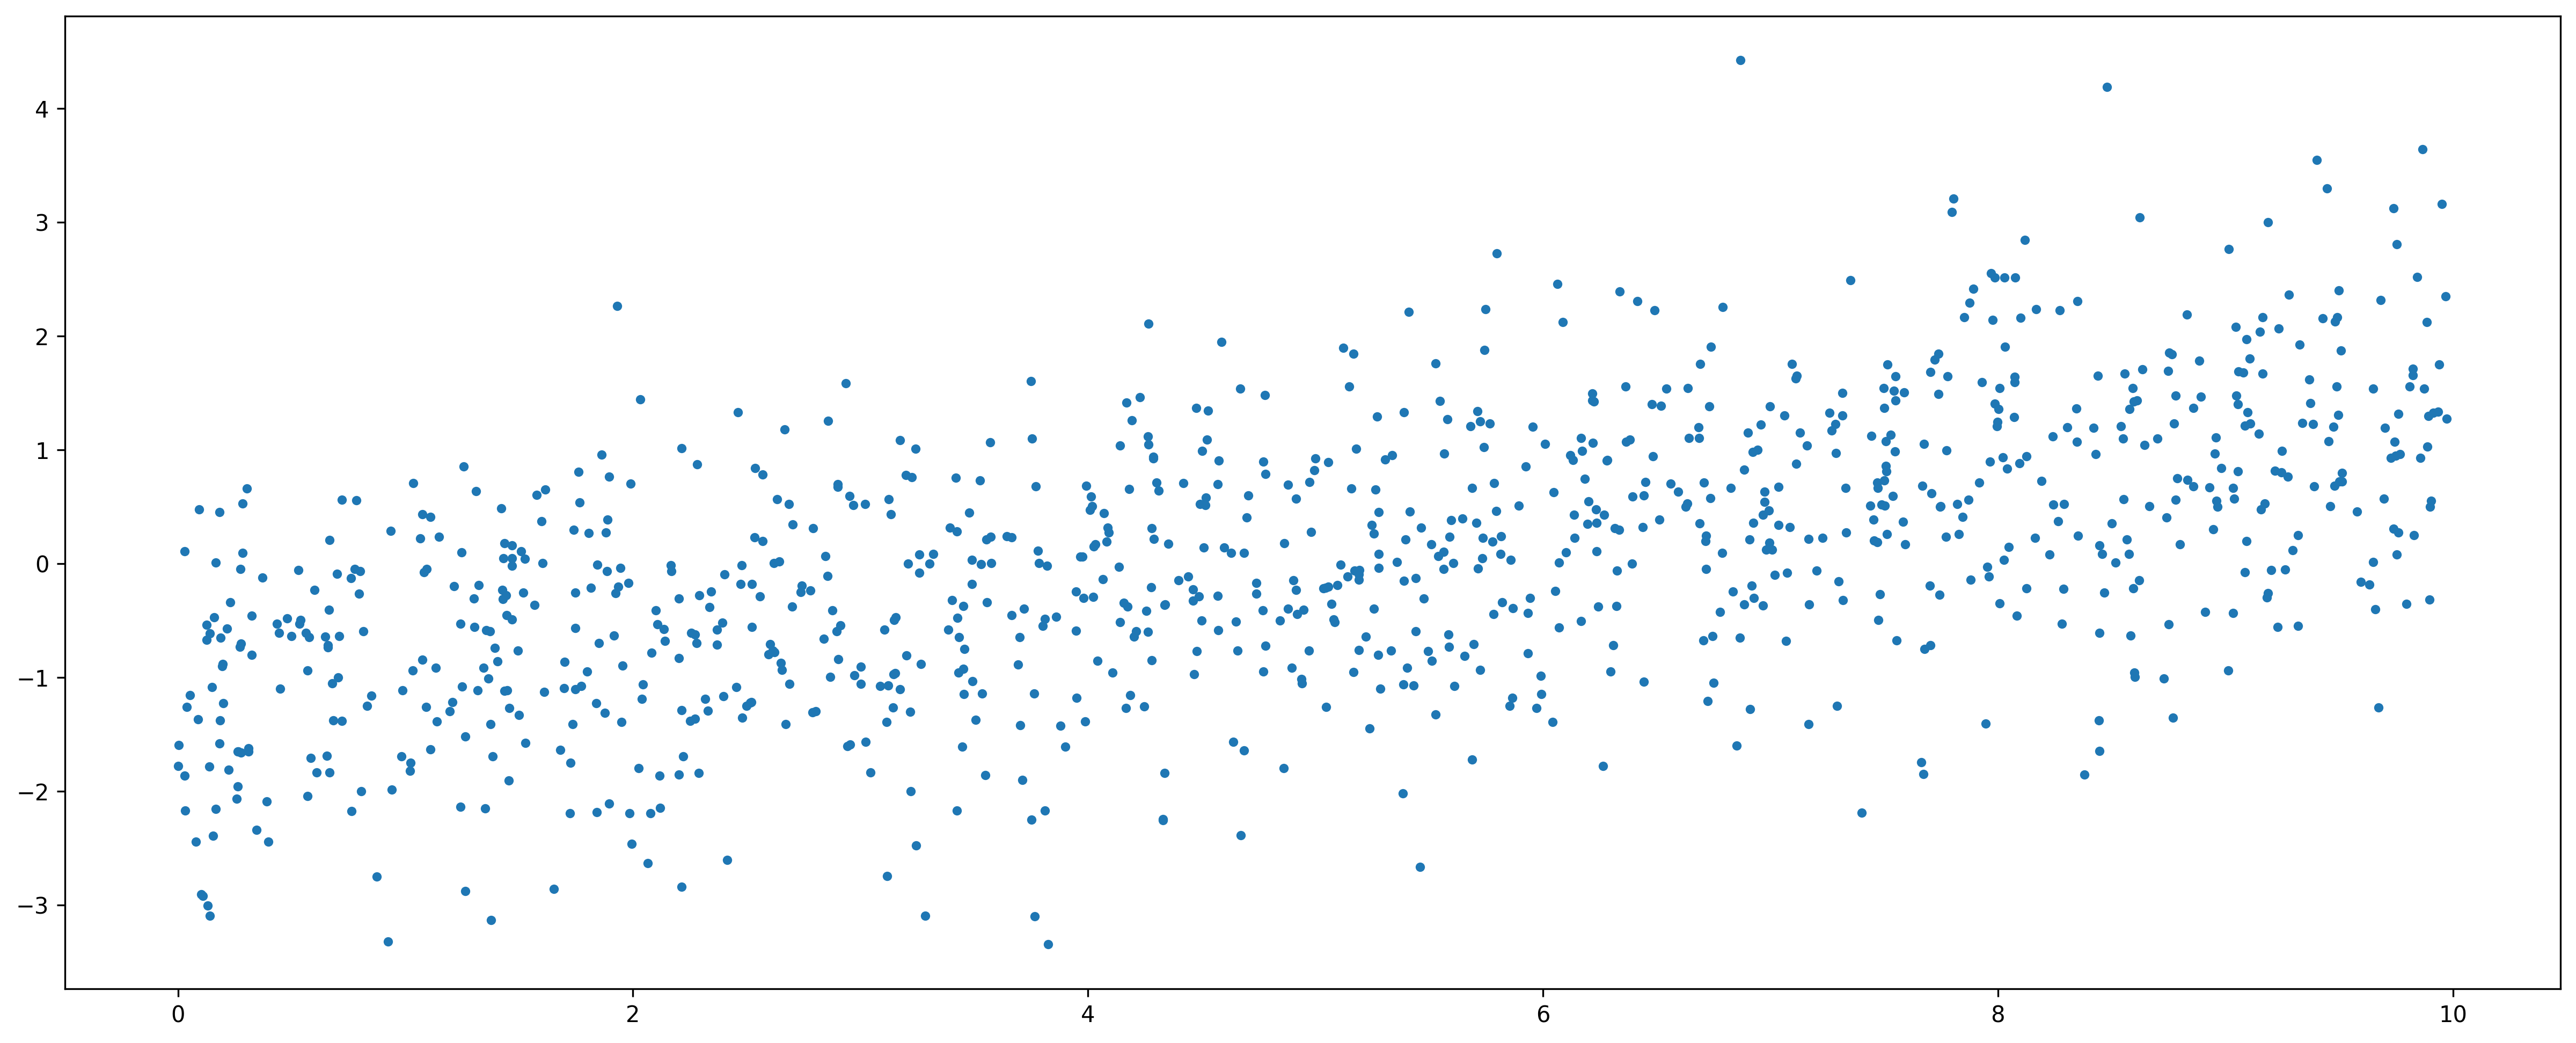

In [10]:
mpl.rcParams['figure.dpi'] = 300
plt.scatter(X, y, s= 10)

## 7.Regressão linear com o Scikit-Learn

Usaremos nossos dados sintéticos recém criados e determinaremos uma linha de melhor ajuste, ou regressão linear, usando o scikit-learn.

In [11]:
lin_reg = LinearRegression()

In [12]:
lin_reg.fit(X.reshape(-1, 1), y)
print(f"INTERCEPTAÇÃO: {lin_reg.intercept_}") # interceptação
print(f"INCLINAÇÃO: {lin_reg.coef_}") # inclinação

INTERCEPTAÇÃO: -1.1612566002825888
INCLINAÇÃO: [0.24002588]


Agora podemos usar o modelo para fazer previsões de valores das características. Faremos isso empregando os mesmos dados utilizados no ajuste do modelo: o array de características, X.

In [13]:
y_pred = lin_reg.predict(X.reshape(-1, 1))

Podemos exibir as previsões, y_pred, da característica X como uma plotagem linear sobre a plotagem dos dados da característica e da resposta como fizemos anteriormente.

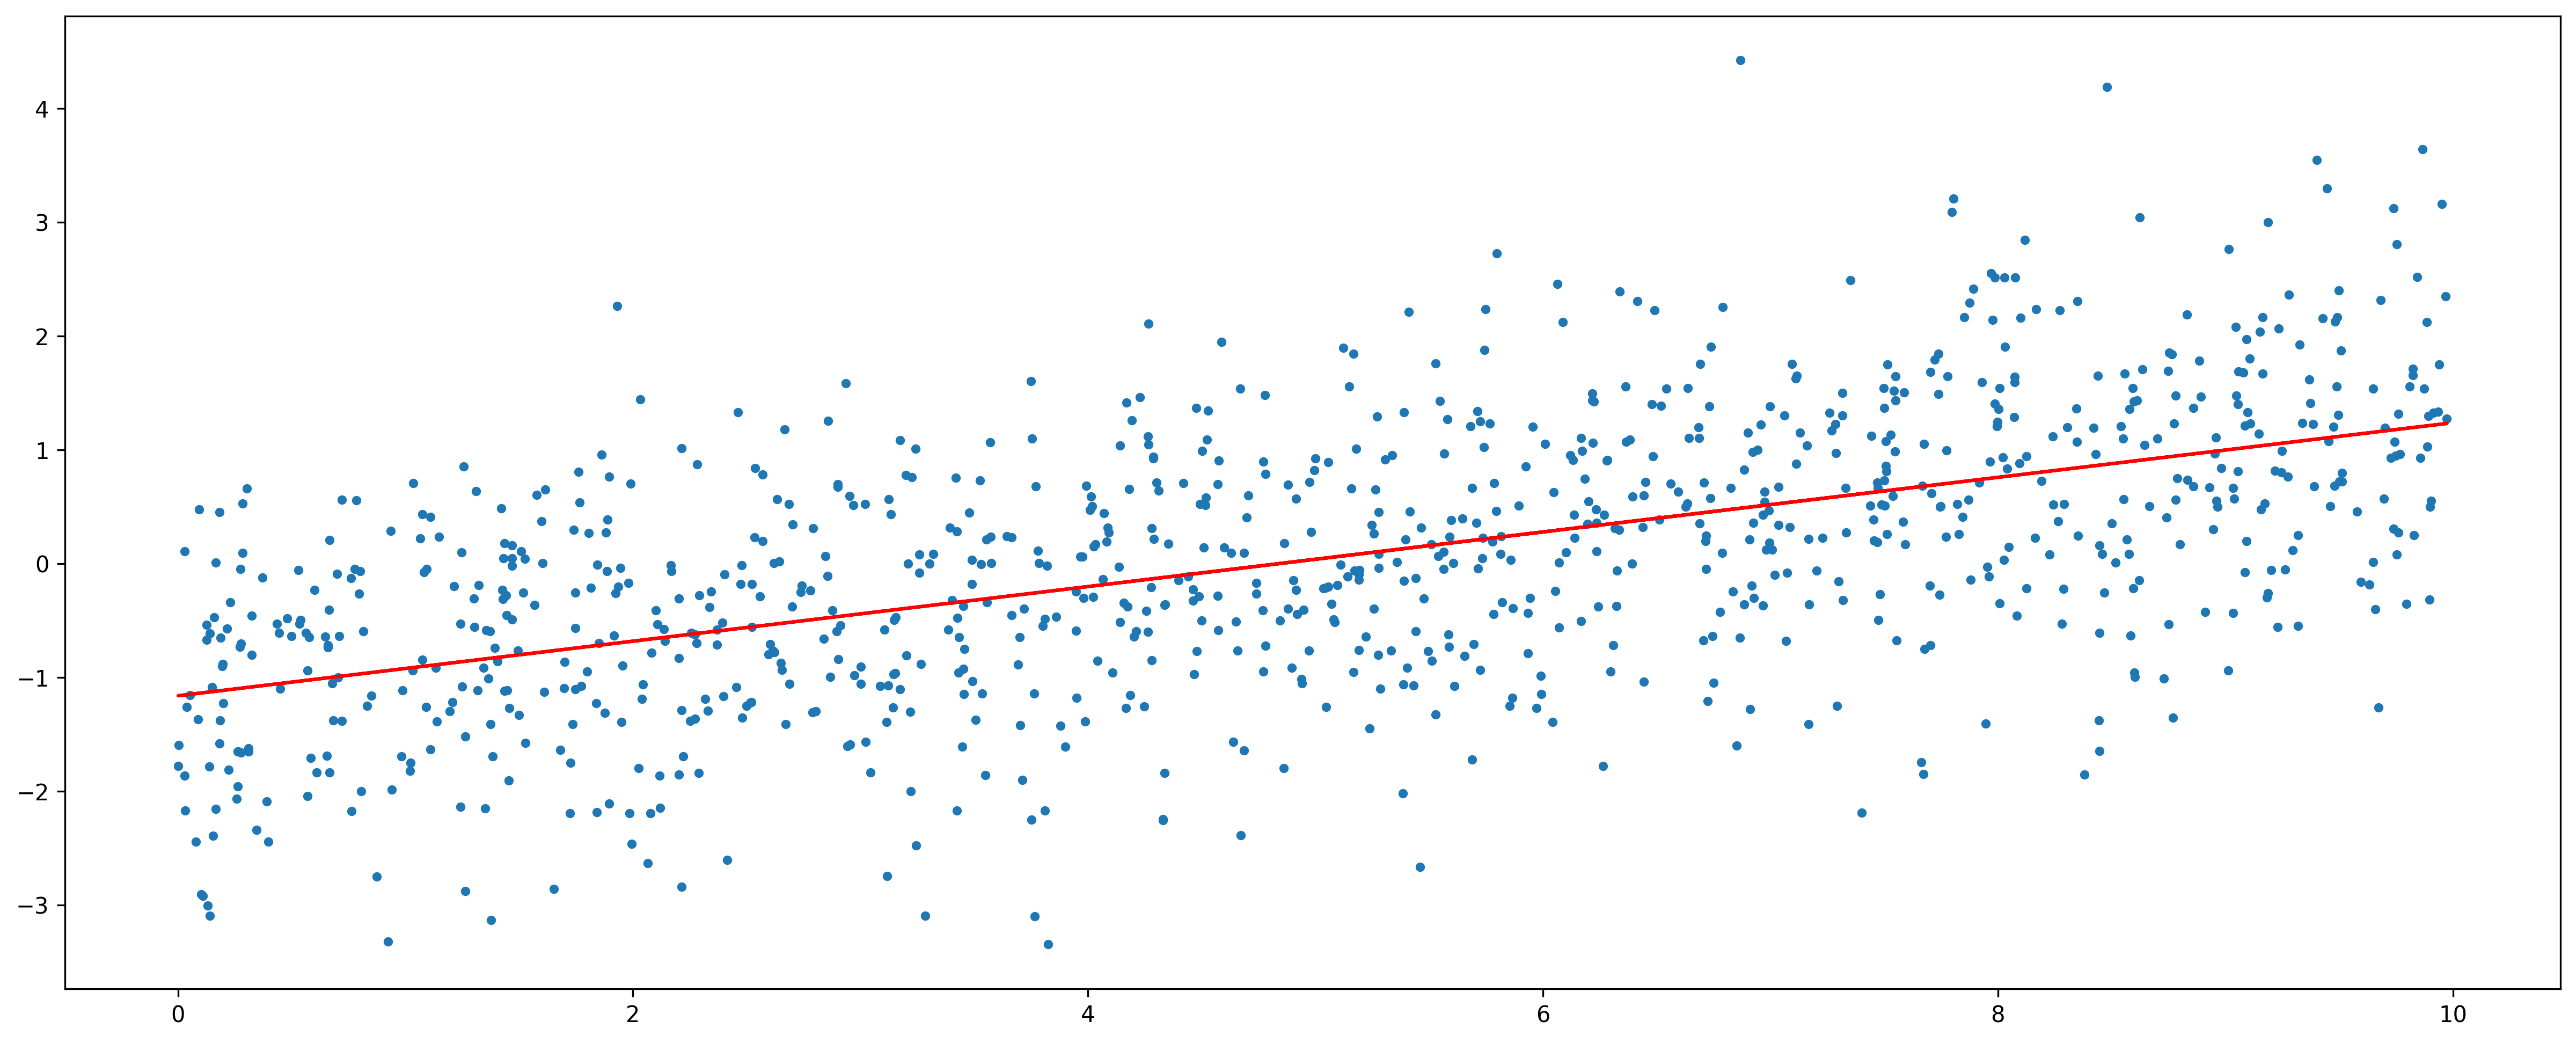

In [14]:
plt.scatter(X, y, s= 10)
plt.plot(X, y_pred, 'r')

A plotagem exibe como seria a linha de melhor ajuste para os dados, como esperávamos. Vemos como o modelo "ajusta" os mesmos dados com os quais foi treinado, anteriormente examinamos previsões do modelo para dados novos desconhecidos. **Em machine learning, geralmente o que nos interessa são os recursos preditivos: queremos modelos que nos ajudem a saber os possíveis resultados de futuros cenários**.

## 8.Métricas de desempenho de modelos para a classificação binária

Até então sabemos como criar um modelo preditivo. Porém, não sabemos o qual bom esse modelo é para o nosso problema. O próximo passo é selecionar uma métrica de desempenho para avaliar a qualidade preditiva de um modelo. Mas antes devemos lembrar de duas coisas:

* ### Conveniência da métrica para o problema

Normalmente as métricas são definidas apenas para uma classe específica de problemas; como de classificação ou de regressão. Para um problema de classificação binária (sim ou não, verdadeiro ou falso, compra ou não compra), existe um nível adicional de detalhe, em outras palavras, com que frequência o modelo está correto para cada classe, as positivas ou negativas. Já para as métricas de regressão, tem como objetivo medir o quanto uma previsão se aproximou do valor alvo. Se estivermos tentando prever o preço de uma casa, o quão perto chegamos? Estamos sistematicamente superestimando ou subestimando? Estamos avaliando as casas mais caras erroneamente e as mais baratas corretamente?

* ### A métrica responde a pergunta da empresa?

Primeiramente vamos deixar claro que para se criar um modelo deve haver uma meta envolvida. Então para conserguirmos responder a pergunta precisa estar envolvida à uma meta. **Em contexto empresarial, as metas típicas são gerar lucro ou reduzir perdas. Basicamente, precisamos que sejam complementares o problema da empresa, que com frequência está relacionado as questões financeiras, e a métrica que irá julgar seu modelo**.

## 9.Dividindo os dados entre conjunto de treinamento e de teste (retenção)

Em nossa tentativa de criar um modelo que tenha capacidade preditiva, precisamos de alguma maneira de medir com eficiência o modelo que pode fazer previsões para dados não usados para ajustá-lo. Isso ocorre porque no ajuste do modelo, este se torna "especializado" no aprendizado do relacionamento entre características e a resposta do conjunto específico de dados rotulados que foram usados no ajuste. Embora isso seja bom, queremos poder usar o modelo para fazer previsões precisas para novos dados não vistos, cujo o valor real dos rótulos não é conhecido.

Os rótulos que não são conhecidos são chamados de **dados de teste**, ou **dados fora da amostra (retenção)** já que são de amostras que não foram usadas no treinamento do modelo. As amostras para treinar o modelo são chamadas de **dados de treinamento**. Separar um conjunto de dados de teste nos dará uma ideia de como será o desempenho do modelo quando ele for usado para sua finalidade, fazer previsões para amostras que não foram incluídas durante seu treinamento.

Vamos dividir os dados de modo que 80% sejam usados para treinamento e 20% sejam reservados para teste. **Esses percentuais são uma maneira comum de fazer a divisão do conjunto de dados, mas não são de modo algum uma regra. Se você tiver um número muito grande de amostras, talvez não precise de um percentual muito alto de treinamento, já que poderá chegar a um conjunto bem extenso e representativo com um percentual mais baixo.**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['EDUCATION'].values.reshape(-1, 1),
                                                    df['default payment next month'].values,
                                                    test_size= 0.2,
                                                    random_state= 24)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 1)
(5333, 1)
(21331,)
(5333,)


Tudo certo até então. O número de amostras dos conjuntos de treinamento e teste é consistente com a divisão 80/20.

Usamos a característica *EDUCATION* apenas para mostrar como dividir dados e calcular diferentes métricas de desempenho do modelo, o que os cientistas dizem como análise por tentativa e erro.

Agora que temos nossos dados de treinamento e teste, devemos certificar se sua natureza é a mesma entre os conjuntos. Especificamente, temos de saber se a fração da classe positiva é semelhante.

In [17]:
print(np.mean(y_train))
print(np.mean(y_test))

0.223102526838873
0.21657603600225014


As frações da classe positiva tanto nos dados de treinamento quanto nos dados de teste são de, aproximadamente, 22%. Isso é bom, já que são quase iguais aos dados gerais e podemos dizer que o conjunto de treinamento é representativo do conjunto de teste.

## 10.Acurácia da classificação

Vamos dar prosseguimento ajustando um modelo de regrassão logística afim de ilustrar as métricas de classificação binária.

In [18]:
example_lr = LogisticRegression(C= 0.1,
                           class_weight= None,
                           dual= False,
                           fit_intercept= True,
                           intercept_scaling= 1,
                           max_iter= 100,
                           multi_class= 'auto',
                           n_jobs= None,
                           penalty= 'l2',
                           random_state= None,
                           solver= 'liblinear',
                           tol= 0.0001,
                           verbose= 0,
                           warm_start= False) 

Vamos usar as amostras do conjunto de dados de treino e, em seguida, usaremos os dados de teste para fazer as previsões.

In [19]:
example_lr.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [20]:
y_pred = example_lr.predict(X_test)

Agora vamos calcular a acurácia do modelo, que é a proporção de amostras classificadas corretamente.

In [21]:
is_correct = y_pred == y_test
print(f"ACURÁCIA = {round((np.mean(is_correct)), 2) * 100}%")

ACURÁCIA = 78.0%


**ATENÇÃO: O próprio scikit-learn oferece métodos que calculam a acuracia do modelo; como o método *`score`* que precisa apenas das características dos dados de teste para fazer previsões e os rótulos de teste.**

In [22]:
print(f"ACURÁCIA = {round(example_lr.score(X_test, y_test), 2) * 100}%")

ACURÁCIA = 78.0%


A primeira vista, uma acurácia de 78% pode parecer boa. No entanto o nosso foco está nas amostras positivas que indicam 22% do nosso dataset. Isso remete dizer que os outros 78% são as classes negativas que o nosso modelo preveu. Isso aconteceu pois o nosso modelo consegue fazer previsões apenas de classes majoritárias.

Continuaremos nossa busca por um modelo que tenha métricas de classificação binária mais complexas afim de suprir nossas amostras negativas e positivas.

### 10.1.Taxa de verdadeiros positivos, taxa de falsos positivos e a matriz de confusão

Falaremos brevemente sobre os rótulos binários: positivo e negativo. O modelo desempenha uma certa acurácia conforme prever as amostras corretamente. A porção de amostras previstas como positivas é chamada de **taxa de verdadeiros positivos (TPR, true positive rate)**. Se dissermos que "P" é o número de amostras da **classe positiva** nos dados de teste, e **TP** é o número de **verdadeiros positivos**, podemos prever o número de amostras da seguinte forma:

* Equação da taxa de verdadeiros positivos:
$$TRP = \frac{TP}P $$

O inverso da taxa de verdadeiros positivos é a **taxa de falsos negativos (FNR, false negative rate)**. Trata-se da proporção de amostras de teste positivas que previmos erroneamente como negativas. Esses erros são chamados de **falsos negativos (FN)**.

* Equação da taxa de falsos negativos:
$$ FNR = \frac {FN}P\ $$

Já que todas as amostras positivas são previstas de maneira correta ou incorreta, a soma do número de verdadeiros positivos e do número de falsos negativos é igual ao número total de amostras positivas.

* Relação entre a TPR e FNR:
$$ TPR + FNR = 1 $$

Okay. Mas em nosso dataset também existe **amostras negativas (N)**, o que remete a dizer que existe também uma taxa de **verdadeiros negativos (TNR, true negative rate)** e a **taxa de falsos positivos (FPR, false positive rate)**. A relação entre TNR e FPR é igua a 1.

* Equação da taxa de verdadeiros negativos:
$$ TNR = \frac {TN}N\ $$

* Equação da taxa de falsos positivos:
$$ FPR = \frac {FP}N\ $$

* Relação entre a TNR e FPR:
$$ TNR + FPR = 1 $$

Cada subgrupo forma um grupo maior chamado de **matriz de confusão**; que nada mais é que uma matriz 2x2 formada por dois eixos: classes verdadeiras e classes previstas.

O que devemos querer de uma matriz de confusão é que TN e TP tenham resultados relativamente maiores que FN e FP pois representam classificações incorretas pelo modelo.

## 11.Calculando as taxas de verdadeiros e falsos positivos e negativos e a matriz de confusão

O código a seguir nos mostra exatamente como uma matriz de confusão funciona. Logo em seguida faremos algumas resalvas de como o modelo se comporta.

In [23]:
metrics.confusion_matrix(y_test, y_pred)

array([[4178,    0],
       [1155,    0]])

A matriz acima mostra que tanto para amostras positivas quanto negativas, o nosso modelo se comporta como um modelo nulo de classe majoritária. Como sabemos, cada classe P (FP e TP) e N (FN e FP) a soma de seus subgrupos devem ser igual a 1. O que está acontecendo no modelo é a previsão de todas as amostras em um mesmo grupo majoritario. Logo, se a classe N possui 4178 amostras e modelo previu 4178 como TN, FP será zero. O mesmo também é verdade para a classe P que possui 1155 amostras e que o modelo previu 1155 como FN e zero para TP. 

## 12.Obtendo probabilidades previstas a partir da medelos de regressão logística 

Vamos usar a regressão logística para fazer previsões no nosso modelo afim de melhorar as probabilidades previtas para as amostras de teste.

In [24]:
y_pred_proba = example_lr.predict_proba(X_test)
y_pred_proba

array([[0.77423402, 0.22576598],
       [0.77423402, 0.22576598],
       [0.78792915, 0.21207085],
       ...,
       [0.78792915, 0.21207085],
       [0.78792915, 0.21207085],
       [0.78792915, 0.21207085]])

Podemos ver que que o código nos retornou duas colunas. Isso porque em nosso dataset existem apenas duas classes: positiva e negativa.

Agora vamos verificar se sua soma é igual a 1:

In [25]:
prob_sum = np.sum(y_pred_proba, 1)
prob_sum

array([1., 1., 1., ..., 1., 1., 1.])

Veremos se nosso conjunto tem o mesmo tamanho que o original:

In [26]:
print(y_test.shape)
print(prob_sum.shape)

(5333,)
(5333,)


Para finalizarmos, veremos se nosso conjunto tem somente o elemento 1:

In [27]:
np.unique(prob_sum)

array([1.])

Vamos fatiar o nosso dataset afim de trabalhar com a classe prevista como positiva, ou seja, a segunda coluna:

In [28]:
pos_proba = y_pred_proba[:, 1]
pos_proba

array([0.22576598, 0.22576598, 0.21207085, ..., 0.21207085, 0.21207085,
       0.21207085])

Agora vamos vizualisar probabilidades previstas em um histograma:

Text(0, 0.5, 'Number of samples')

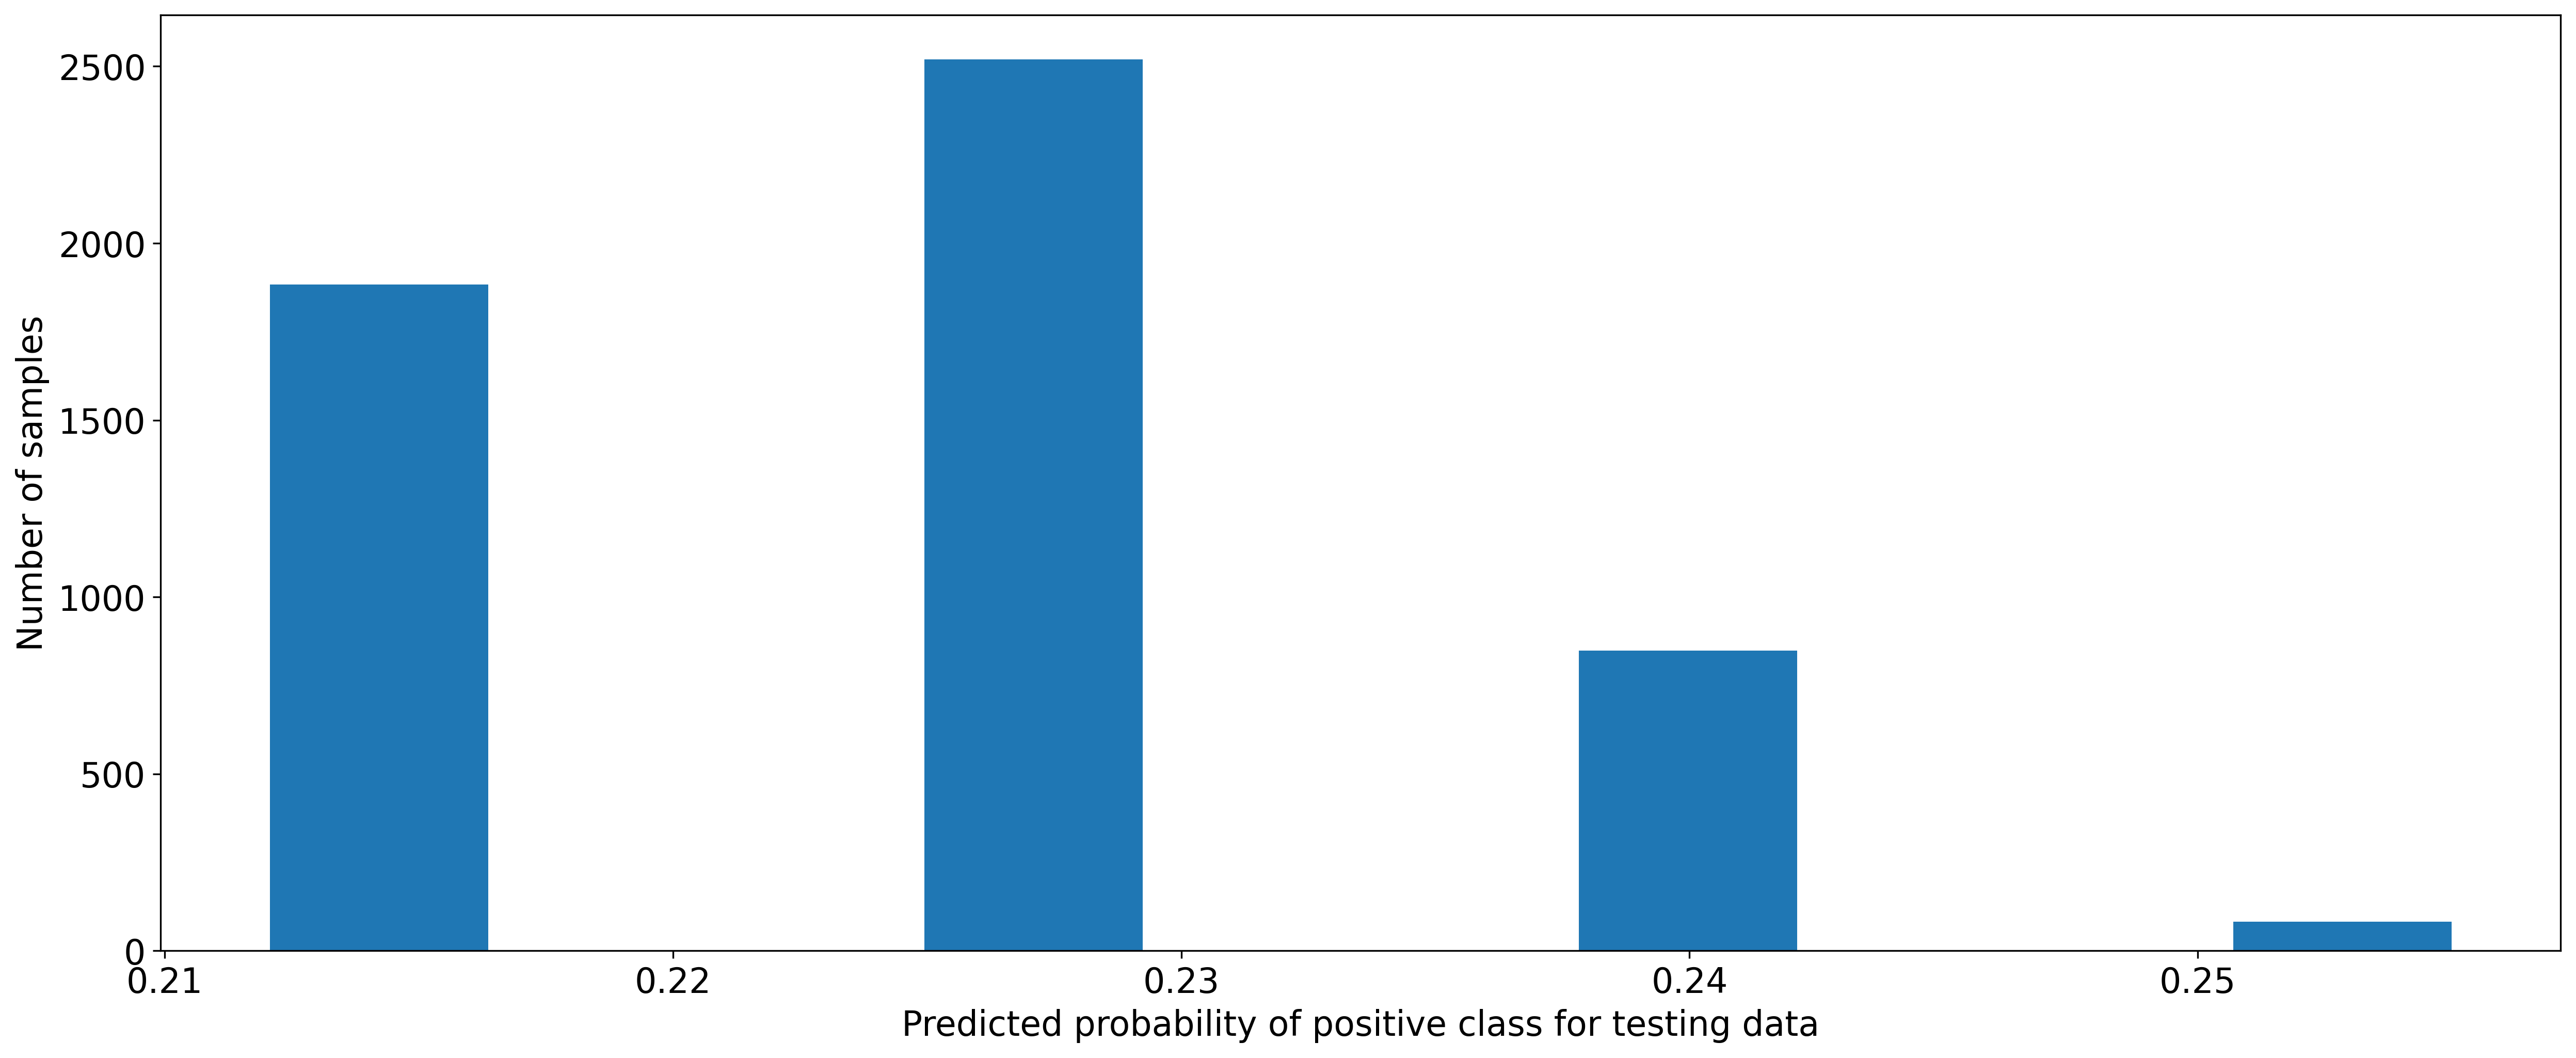

In [29]:
mpl.rcParams['font.size'] = 16
plt.hist(pos_proba)
plt.xlabel("Predicted probability of positive class for testing data")
plt.ylabel("Number of samples")

Esse histograma nos proporciona informações úteis:
* Existem apenas quatro bins com amostras pois há apenas quatro valores exclusivos para a característica `EDUCATION`;
* As probabilidades estão abaixo de 0.5 que é o seu limite padrão; prevendo todas as amostras como negativas. Caso quiséssemos alterar o valor máximo afim de pegar o quarto bin da extrema direita, o melhor ajuste seria para 0.25 e então se tornaria positivo. 

Podemos melhorar nossa visualização dividindo nossa amostras em rótulos verdadeiramente positivas e negativas. Vamos indexar nosso array de probabilidades previstas com máscaras lógicas:

In [30]:
pos_sample_pos_proba = pos_proba[y_test == 1]
neg_sample_pos_proba = pos_proba[y_test == 0]

Vamos jogar novamente em um gráfico só que dessa vez usaremos um gráfico de barras empilhadas:

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'Number of samples')

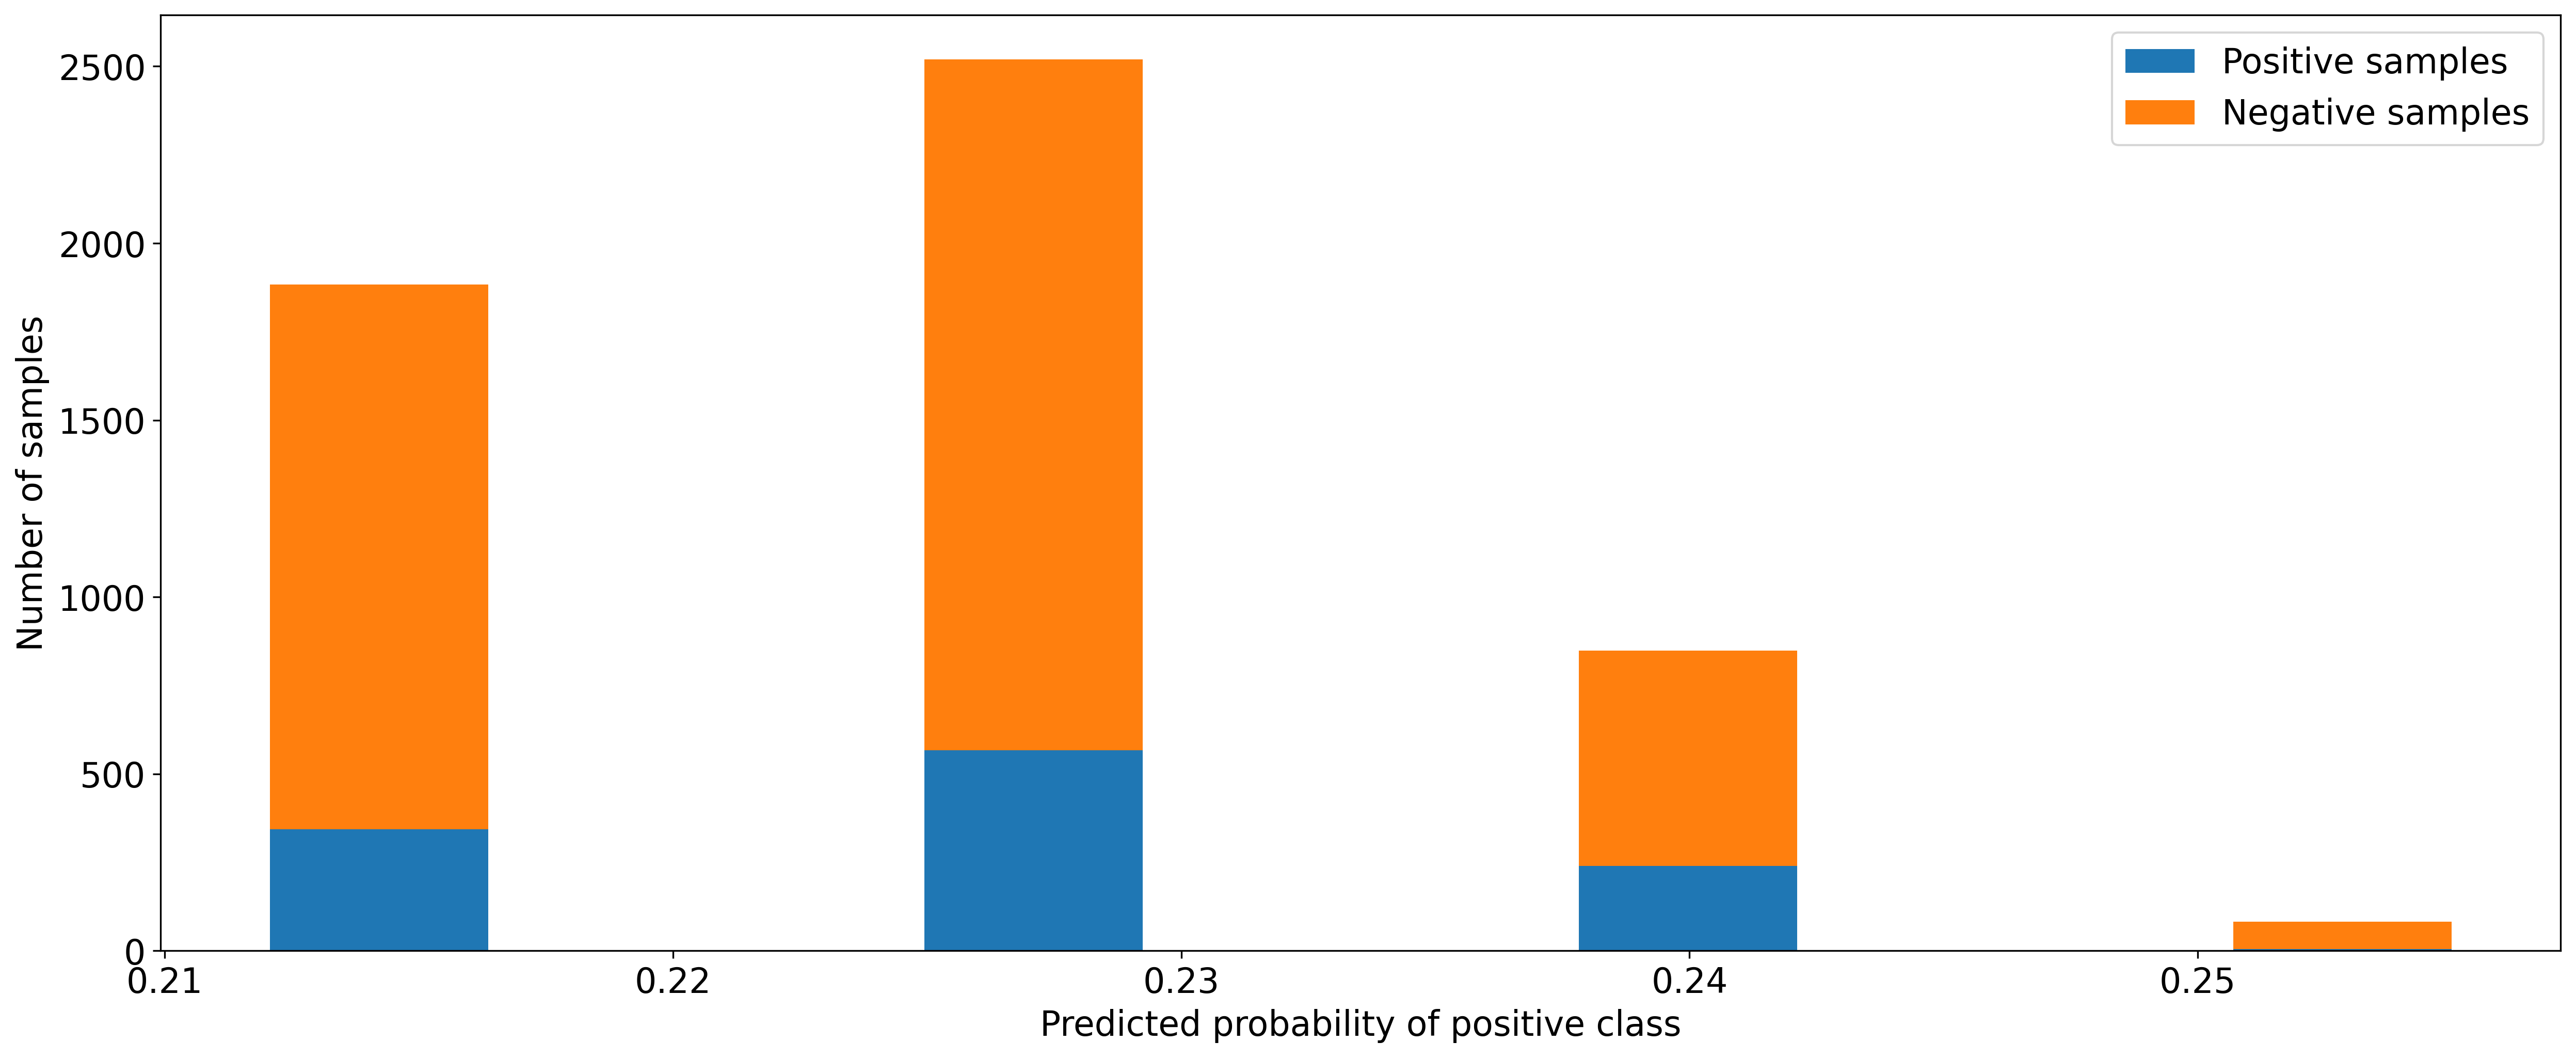

In [31]:
plt.hist([pos_sample_pos_proba, neg_sample_pos_proba],
         histtype= 'barstacked')
plt.legend(['Positive samples', 'Negative samples'])
plt.xlabel("Predicted probability of positive class")
plt.ylabel("Number of samples")

Já que quase todas as amostras do quarto bin na extrema direita são negativas, diminuir o limite maximo para 0.25 apenas diminuiria ainda mais a acurácia do modelo. Seriam classificadas erroneamente como positivas e aumentaríamos a nossa taxa de falsos positivos. Ao mesmo tempo, não teríamos classificado muitas amostras corretamente no caso do quarto bin.

## 13.Curva ROC (Receiver Operating Characteristic)

Precisamos encontrar um ponto de equilíbrio no qual possamos recuperar com sucesso verdadeiros positivos suficientes sem gerar excesso de falsos positivos. Em outras palavras, devemos achar um classificador que trabalhe em um limite que faça a taxa de verdadeiros positivos crescer mais rapidamente que a taxa de falsos negativos. 

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)

Text(0.0, 1.0, 'ROC curve')

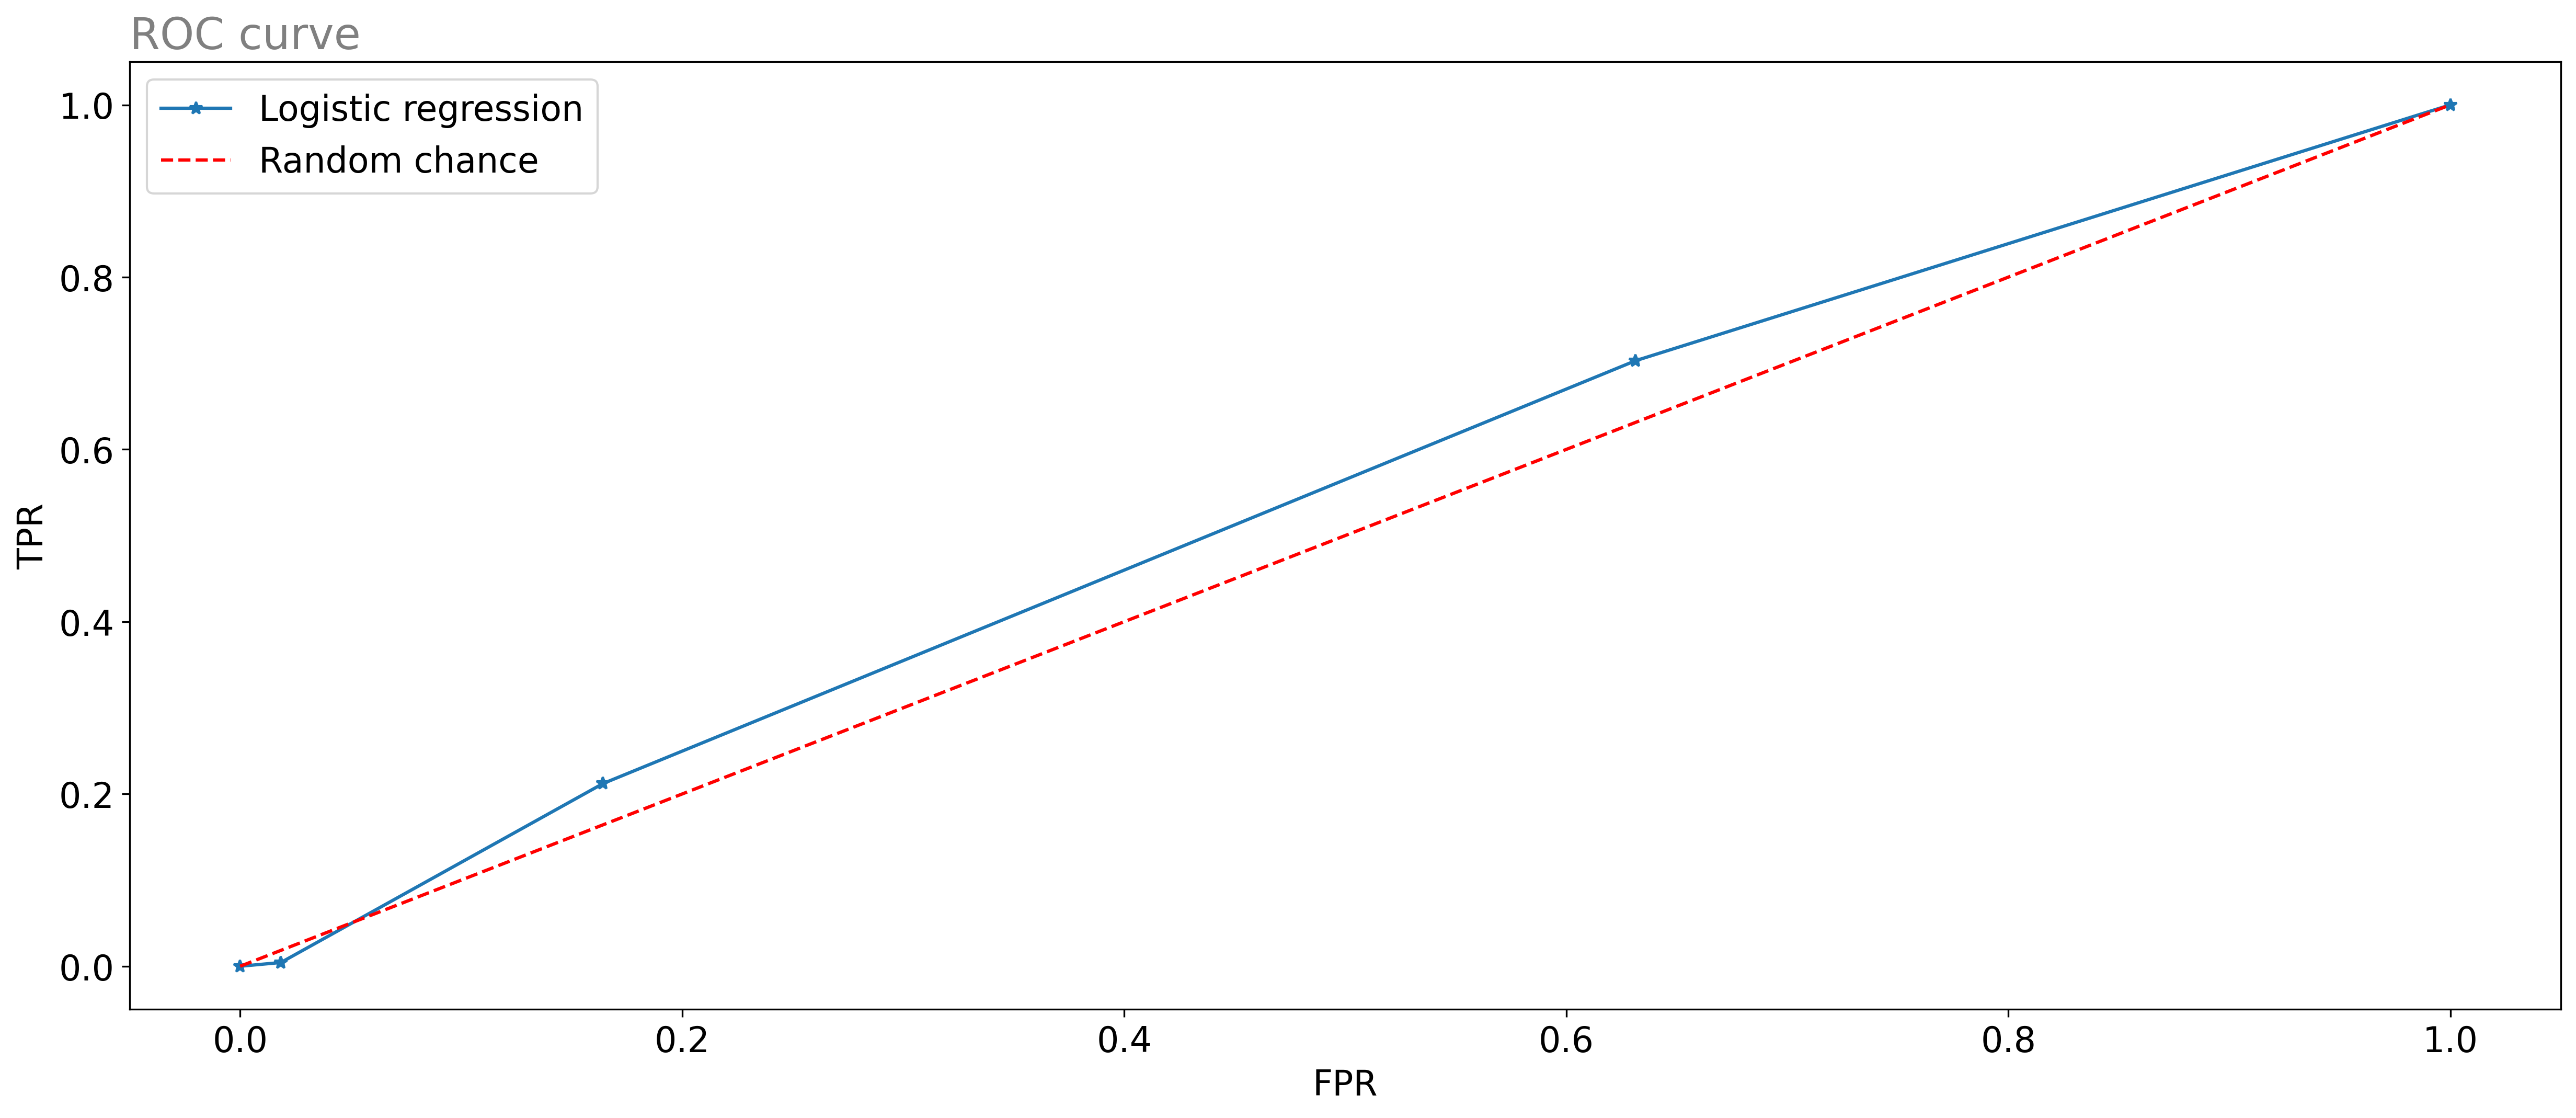

In [39]:
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve',
          loc= 'left',
          fontsize= 20,
          c='grey')

Podemos ver que ela começa em (0,0) com um limite suficientemente alto para que não haja classificações positivas. Há um aumento na taxa de falsos falsos positivos e um aumento muito menor na taxa de verdadeiros positivos.

Outra forma de procurarmos respostas é analisando a curva AUC (area under the curve) da curva ROC. Geralmente, a curva AUC fica entre os intervalos 0.5 e 1 que, resumidamente, quanto mais próximo de 0.5, o modelo tende a calcular amostras aleatoriamente e quanto mais próximo de 1, melhor o desempenho na  previsão.

In [42]:
metrics.roc_auc_score(y_test, pos_proba)

0.5434650477972642

A ROC AUC da regressão logística chega perto dos 0.5, o que significa que ela não é um classificador muito eficaz.